# <img style="float: left; padding: 0px 10px 0px 0px;" src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/84/Escudo_de_la_Pontificia_Universidad_Cat%C3%B3lica_de_Chile.svg/1920px-Escudo_de_la_Pontificia_Universidad_Cat%C3%B3lica_de_Chile.svg.png"  width="80" /> MDS2030 - Introducción a Ciencia de Datos
**Pontificia Universidad Católica de Chile**<br>
**Magister en Ciencia de Datos**<br>

# Tutorial 2: Extracción de datos desde una API.

Este tutorial tiene com objetivo demostrar el uso de la librería `requests` para hacer consultas y recibir respuestas de una API, con el fin de extraer conjuntos de datos disponibles en plataformas online.

Como referencia, se sugiere revisar la documentación de la librería `requests`, disponible en el siguiente link:

https://requests.readthedocs.io/en/latest/


- **Nota:** Este Notebook está disponible como lectura Obligatoria de la semana.


## Ejemplo 1: API del Banco Mundial (World Bank)

La API de indicadores del Banco Mundial provee acceso programático a cerca de 16,000 series de tiempo de indicadores disponibles en plataformas online como Databank (https://databank.worldbank.org/). Muchas series de tiempo llegan hasta más de 50 años atrás, y pueden ser usadas para crear aplicaciones y análisis interesantes.

La información general de la API del Banco Mundial está diponible en este link:

https://datahelpdesk.worldbank.org/knowledgebase/articles/889392-about-the-indicators-api-documentation

Y en particular, las isntrucciones para consultar la API están acá:

https://datahelpdesk.worldbank.org/knowledgebase/articles/898581


Primero veamos como extrar el listado de todos los datos de la API Country, en formato JSON.

In [ ]:
import requests
import pandas as pd

url='http://api.worldbank.org/v2/country'

In [ ]:
# Primero veamos el caso de una query general, sin definir parámetros.
response=requests.get(url)
response.content

Por defecto, la API entrega resultados en formato XML. Para obtenerlos en formato JSON, es necesario especificar
el parámetro `format`

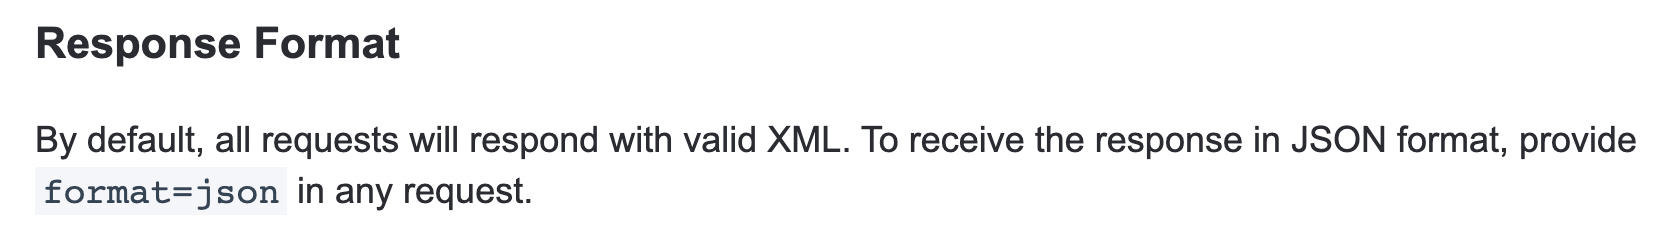

In [ ]:
#Por defecto, la API entrega resultados en formato XML. Para obtenerlos en formato JSON, es necesario especificar
#el parámetro 'format'

response=requests.get(url,params={'format':'json'})
response.content

In [ ]:
#Otra opción: incluir parámetros directamente en el string url
url_query='http://api.worldbank.org/v2/country?format=json'
response=requests.get(url_query)
response.content

Inspeccionemos ahora el contenido de la respuesta:

In [ ]:
json=response.json()
json

In [ ]:
json[0]

La respuesta de la API es una lista de diccionarios. El primero de ellos contiene información general de los datos, y el segundo contiene los datos de interés relativos a países.

In [ ]:
json[1]

In [ ]:
#Podemos llevar estos datos a un DataFrame de pandas
df=pd.DataFrame(json[1])
df

Dado que los datos contienen diccionarios anidados, es necesario usar la función `json_normalize`para generar un DataFrame aplanado.

In [ ]:
df=pd.json_normalize(json[1])
df

Podemos repetir el ejercicio completo para una consulta más específica, por ejemplo, solicitando sólo la información de los países de bajo nivel de ingresos (Low Income Country). De acuerdo a la documentación de la API, esto requiere definir el parámetro `incomeLevel=LIC`

In [ ]:
response=requests.get(url,params={'format':'json','incomeLevel':'LIC'})
json=response.json()
df2=pd.json_normalize(json[1])
df2.head(10)

## Ejemplo 2: API Yelp Fusion ¿Dónde puedo comer en Santiago?

La aplicación Yelp permite a los usuarios calificar y enviar comentarios sobre distintos negocios, y disponibiliza esta información mediante un conjunto de APIs.

https://www.yelp.com/developers/documentation/v3/get_started

Para conectarse a estas APIs, se requiere una clave privada de autentificación (gratuita), que puede ser creada siguiendo las instrucciones en:

https://www.yelp.com/developers/documentation/v3/authentication

En esje ejmplo, usaremos la API *Businesses Search* para obtenre un listado de restaurants en la ciudad de Santiago. La información requerida para hacer la búsqueda está disponible en:

https://www.yelp.com/developers/documentation/v3/business_search

Una característica importante de la API, es que entrega un **máximo de 1000 resultados**. Además, cada query tiene un límite de 50 resultados. Por lo tanto, es necesario **iterar y realizar varias queries para obtener el máximo de 1000 registros**. Para esto, se utiliza el parámetro `offset`, que permite ir avanzando en la lista.

In [ ]:
#url de la API
api_url='https://api.yelp.com/v3/businesses/search'

#estos datos corresponden a una cuenta de usuario creada previamente
clientid='GWOCZh9-BmZxtdsAjr7Gug'
apikey='FHVvXoNmTXIl9DuxYis7AV5uLPujm9MLwrhgs5NgvCfaOxd3V6mxt6dQU8eEqYJiGxe816XATx7ufWjbMWqbV-2Uku1jxBJv8BGRC74NroLPl27PDQqs0tDixit-YHYx'
headers={'Authorization':'Bearer %s'%apikey}

In [ ]:
params={'term':'restaurants','location':'RM Santiago, Chile','limit':50}
response=requests.get(api_url,params=params,headers=headers)
data=response.json()
data

In [ ]:
#Veamos los keys del diccionario recibido
data.keys()

In [ ]:
#El primer elemento del diccionario indica el total de restaurants existentes en la API
print('En total la base de datos registra %d restaurants'%data['total'])

In [ ]:
data['businesses']

La data entregada por la API Yelp API es un objeto en formato JSON anidado, es decir, un diccionario donde algunos de los valores de atributos corresponden a su vez a listas o diccionarios.

Como vimos anteriormente, podemos llevar estos datos a un formato "aplanado" o "flattened",utilizando la función `json_normalize()` :

https://pandas.pydata.org/docs/reference/api/pandas.json_normalize.html

In [ ]:
#normalizamos el contenido del diccionario "businesses"
rests = pd.json_normalize(data["businesses"],sep='_',record_path=['categories'],meta=['name','price','rating','review_count','distance',['coordinates','latitude'],['coordinates','longitude'],['location','address1']],errors='ignore')
rests.head()

La API cuenta con información relativa a 2300 restaurantes, pero en cada consulta se extrae una página con 50 resultados. Por lo tanto, para extraer todos los datos, será necesario iterar el proceso. El parámetro `offset` de la API indica el número de registros a avanzar en cada consulta (avanzamos de 50 en 50).

In [ ]:
#iteramos
offset=0

#creamos una lista para reunir los dataframes creados para cada una de las consultas
allrests=[]

#iteramos hasta llegar a 1000 resultados (el máximo que permite la API)
while offset<=950:
    
    #parámetros de la consulta a la API
    params={'term':'restaurants','location':'RM Santiago, Chile','limit':50,'offset':offset}

    response=requests.get(api_url,params=params,headers=headers)
    data=response.json()
    
    #dataframe con 50 resultados
    rests = pd.json_normalize(data["businesses"],sep='_',record_path=['categories'],meta=['name','price','rating','review_count','distance',['coordinates','latitude'],['coordinates','longitude'],['location','address1']],errors='ignore')

    #agregamos este resultado a la lista de dataframes
    allrests.append(rests)
    
    #avanzamos 50 registros
    offset=offset+50
    

In [ ]:
#Finalmente concatenamos todos los dataframes para crear uno solo con todos los resultados
rests=pd.concat(allrests,ignore_index=True)
rests